#**EVALUACIÓN RNNs PARA PREDICCIÓN DE VALORES BURSATILES FUTUROS**
**(CASO TESLA)**

JOSE PEIRÓ CARDONA

In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# **Parte I: Preparación de los datos**

Los datos los hemos descargado de Yahoo Finance: https://finance.yahoo.com/quote/TSLA/history?period1=1436486400&period2=1594339200&interval=1d&filter=history&frequency=1d&guccounter=1&guce_referrer=aHR0cHM6Ly90b3dhcmRzZGF0YXNjaWVuY2UuY29tLw&guce_referrer_sig=AQAAABaQdHwxB1TaDUpkBTwVVmfpgtMKPPNJTnRfmNOKzZkLFiFSTycdWNiIf3NTIQ-fTH-LGLvjWT4V5kGKWOPBIlSLJNCVqENx2wW7tIGN6CX6jtED5EhiCN1PIG28BbzlFC0XqLgvX13Oi3RY6m0Jq8c2toZXD31ZgkSu-GVdJ9KJ

In [2]:
df=pd.read_csv("TSLA.csv")
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (1259, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,17.481333,17.533333,17.188000,17.276667,17.276667,39163500
1,2015-07-13,17.483334,17.503332,17.070000,17.477333,17.477333,44404500
2,2015-07-14,17.473333,17.732668,17.367332,17.709999,17.709999,28614000
3,2015-07-15,17.782667,17.832666,17.472000,17.542667,17.542667,30324000
4,2015-07-16,17.614668,17.813334,17.544001,17.778667,17.778667,24240000


In [3]:
# Calcula estadísticas descriptivas sobre el dataset
descriptive_stats = df[['Open', 'Close']].describe()

# Muestra las estadísticas descriptivas
print(descriptive_stats)

              Open        Close
count  1259.000000  1259.000000
mean     21.531375    21.547353
std      11.133586    11.172914
min       9.488000     9.578000
25%      15.287333    15.295667
50%      18.922001    18.982000
75%      22.654001    22.596666
max      93.667336    92.952003


Número de observaciones (Count): Hay 1259 observaciones tanto para los precios de apertura como para los precios de cierre. Esto indica que no hay valores faltantes en el conjunto de datos.

Promedio (Mean): El precio promedio de apertura es aproximadamente 21.53 dólares, mientras que el precio promedio de cierre es ligeramente mayor, alrededor de 21.55 dólares. Esto sugiere que, en promedio, las acciones de Tesla tienden a cerrar un poco más altas de lo que abren durante el período considerado.

Desviación estándar (Std): La desviación estándar de los precios de apertura es de aproximadamente 11.13 dólares, mientras que para los precios de cierre es de aproximadamente 11.17 dólares. Esto indica que hay una cantidad significativa de variabilidad en los precios tanto en la apertura como en el cierre.

Mínimo y Máximo (Min y Max): El precio mínimo de apertura registrado es de alrededor de 9.49 dólares, mientras que el precio mínimo de cierre es de aproximadamente 9.58 dólares. Por otro lado, el precio máximo de apertura observado es de aproximadamente 93.67 dólares, mientras que el precio máximo de cierre es de alrededor de 92.95 dólares. Estos valores proporcionan el rango en el que se han movido los precios de las acciones durante el período considerado.

In [4]:
df['Date'] = pd.to_datetime(df['Date'])

# Obtener el año de cada fecha
df['Year'] = df['Date'].dt.year

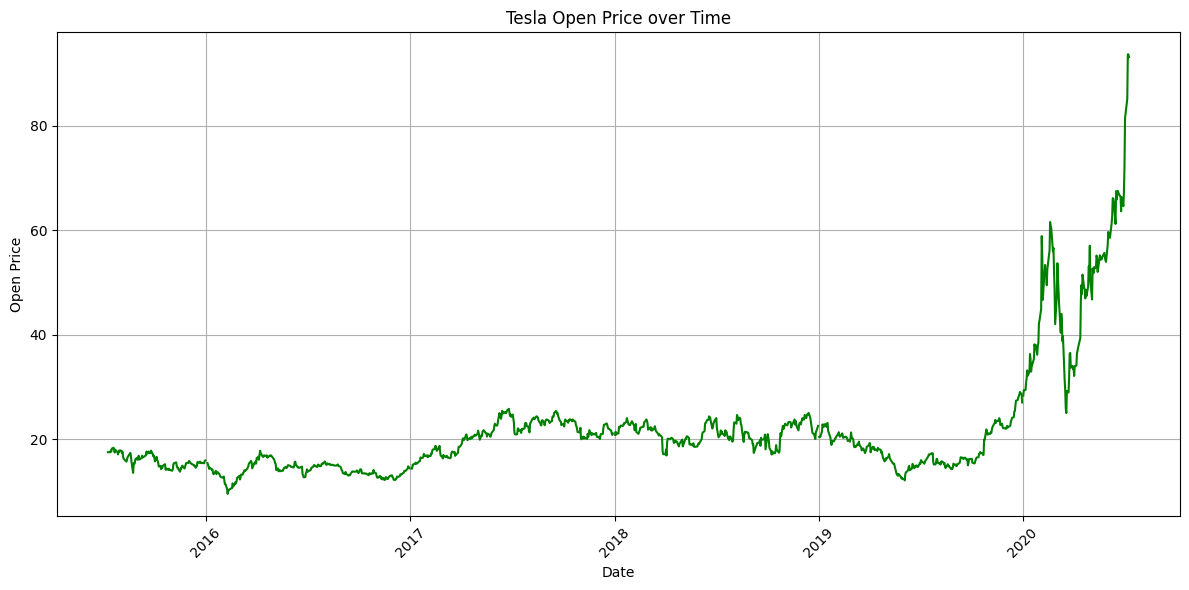

In [5]:
# Visualizar la serie temporal de 'Open' (Apertura)
plt.figure(figsize=(12, 6))
for year in df['Year'].unique():
    year_data = df[df['Year'] == year]
    plt.plot(year_data['Date'], year_data['Open'], color='green')

plt.title('Tesla Open Price over Time')
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

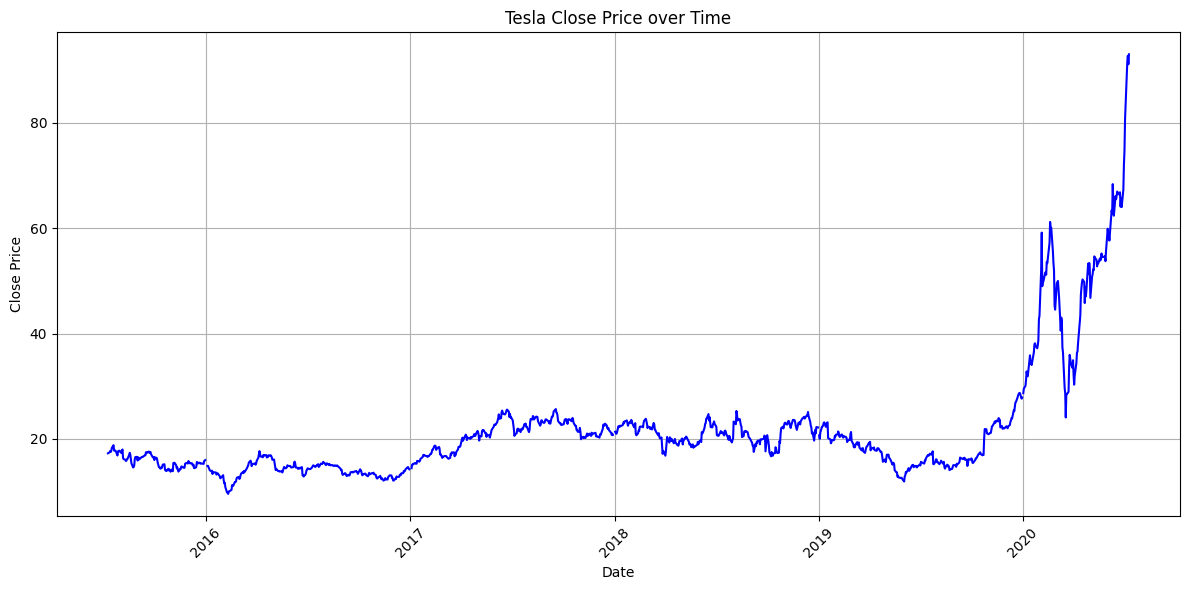

In [6]:

# Visualizar la serie temporal de 'Close'
plt.figure(figsize=(12, 6))
for year in df['Year'].unique():
    year_data = df[df['Year'] == year]
    plt.plot(year_data['Date'], year_data['Close'], color='blue')

plt.title('Tesla Close Price over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

**Preparación de los Datos**

In [7]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba
train_size = int(len(df) * 0.8)  # 80% para entrenamiento
val_size = int(train_size * 0.1)  # 10% del entrenamiento para validación
test_size = len(df) - train_size  # Resto para prueba

train_data = df.iloc[:train_size, 4:5].values
val_data = df.iloc[train_size:train_size+val_size, 4:5].values
test_data = df.iloc[train_size+val_size:, 4:5].values

print("Dimensiones de train_data:", train_data.shape)
print("Dimensiones de val_data:", val_data.shape)
print("Dimensiones de test_data:", test_data.shape)

Dimensiones de train_data: (1007, 1)
Dimensiones de val_data: (100, 1)
Dimensiones de test_data: (152, 1)


**Preprocesamiento de datos y estructuración para RNNs**

In [8]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = sc.fit_transform(train_data)
val_data_scaled = sc.transform(val_data)
test_data_scaled = sc.transform(test_data)

# Crear estructura de datos con 60 pasos de tiempo y 1 salida
def create_dataset(dataset, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(dataset)):
        X.append(dataset[i-time_steps:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data_scaled)
X_val, y_val = create_dataset(val_data_scaled)
X_test, y_test = create_dataset(test_data_scaled)

# Reorganizar para LSTM: (muestras, pasos de tiempo, características)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Reorganizar para LSTM: (muestras, características)
#agrega una dimensión adicional a tus datos de salida, convirtiéndolos en matrices bidimensionales en lugar de unidimensionales.
#Esto asegura que tus datos de entrada y salida tengan la misma estructura y sean compatibles con tu modelo de RNN.
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Mostrar las dimensiones de los datos de entrenamiento y prueba
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_test:", X_test.shape)
print("Dimensiones de X_val:", X_val.shape)
print("Dimensiones de y_train:", y_train.shape)
print("Dimensiones de y_test:", y_test.shape)
print("Dimensiones de y_val:", y_val.shape)


Dimensiones de X_train: (947, 60, 1)
Dimensiones de X_test: (92, 60, 1)
Dimensiones de X_val: (40, 60, 1)
Dimensiones de y_train: (947, 1)
Dimensiones de y_test: (92, 1)
Dimensiones de y_val: (40, 1)


# **Parte II: Modelado con Recurrent Neural Networks (RNNs)**

**SimpleRNN**

En el código, se implementa un modelo de red neuronal recurrente simple (SimpleRNN) para predecir el precio de las acciones de Tesla. Se utiliza la función de activación ReLU (Rectified Linear Unit) en la capa SimpleRNN. ReLU se elige comúnmente en las capas ocultas de las redes neuronales debido a su eficacia en la superación del problema de desvanecimiento del gradiente y su rapidez de convergencia en el entrenamiento.

El optimizador Adam se selecciona para la compilación del modelo. Adam es una variante del descenso de gradiente estocástico (SGD) que combina ideas de otros métodos de optimización, como el momento y la adaptación de la tasa de aprendizaje. Proporciona una convergencia rápida y eficiente, adaptando de manera dinámica las tasas de aprendizaje para cada parámetro del modelo.

Para evaluar el rendimiento del modelo durante el entrenamiento, se utiliza la función de pérdida Mean Squared Error (MSE). El MSE calcula la media de los cuadrados de las diferencias entre las predicciones del modelo y los valores reales. Es una métrica comúnmente utilizada en problemas de regresión, como la predicción de series temporales, donde el objetivo es minimizar la discrepancia entre las predicciones y los valores observados.

Una vez compilado el modelo con Adam y MSE, se procede al entrenamiento con los datos de entrenamiento. Durante el entrenamiento, se monitorea la pérdida tanto en los datos de entrenamiento como en los datos de validación para evaluar la capacidad de generalización del modelo. Se grafican las pérdidas de entrenamiento y validación a lo largo de las épocas para visualizar la evolución del rendimiento del modelo durante el proceso de entrenamiento.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4224      
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4289 (16.75 KB)
Trainable params: 4289 (16.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
30/30 [==============================] - 5s 58ms/step - loss: 0.0922 - val_loss: 0.0148
Epoch 2/100
30/30 [==============================] - 1s 39ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 3/100
30/30 [==============================] - 1s 37ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 4/100
30/30 [==============================] - 1s 44ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 5/100
30/30 

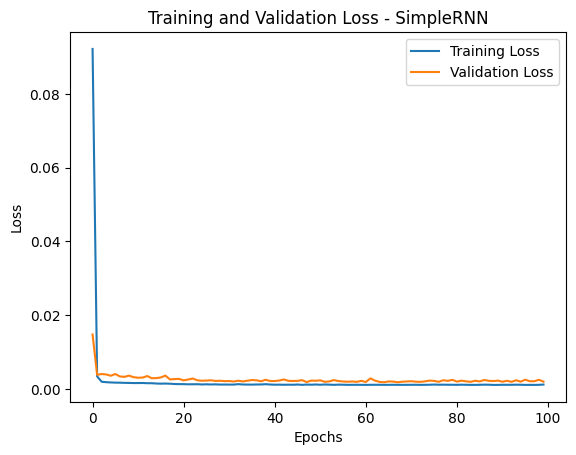

3/3 [==============================] - 0s 13ms/step


In [10]:
from keras.layers import SimpleRNN

# Modelo SimpleRNN
model_simple_rnn = Sequential([
    SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(units=1)
])

# Compilar el modelo
model_simple_rnn.compile(optimizer='adam', loss='mean_squared_error')

#Visualizar modelo
model_simple_rnn.summary()

# Entrenar el modelo
history_simple_rnn = model_simple_rnn.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Graficar la pérdida durante el entrenamiento para SimpleRNN
plt.plot(history_simple_rnn.history['loss'], label='Training Loss')
plt.plot(history_simple_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - SimpleRNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Descenso inicial pronunciado: Al principio del entrenamiento (desde aproximadamente la época 0 hasta alrededor de la época 10), tanto la pérdida de entrenamiento como la de validación disminuyen rápidamente. Esto sugiere que el modelo está aprendiendo rápidamente los patrones presentes en los datos de entrenamiento.

Meseta: Tras el descenso inicial, tanto la pérdida de entrenamiento como la de validación se estabilizan. Los valores de pérdida se mantienen relativamente constantes desde alrededor de la época 10 hasta el final del proceso de entrenamiento (época 100). Esto indica que el modelo ha alcanzado un punto en el que un mayor entrenamiento no mejora significativamente su rendimiento.

Sobreajuste: La diferencia entre la pérdida de entrenamiento y la de validación sugiere que el modelo podría estar sobreajustándose a los datos de entrenamiento. El sobreajuste ocurre cuando el modelo se adapta excesivamente a los datos de entrenamiento y no generaliza bien a datos no vistos. En este caso, la pérdida de entrenamiento es consistentemente menor que la de validación.

In [33]:
test_loss = model_simple_rnn.evaluate(X_test, y_test)
print("Test Loss:", test_loss)


3/3 [==============================] - 0s 27ms/step - loss: 0.3750
Test Loss: 0.37498340010643005


**SimpleRNN mejorada (regularización)**


La regularización L2 penaliza los coeficientes grandes en la función de pérdida para evitar el sobreajuste, mejorando así la generalización del modelo.
El learning rate de 0.01 que aplicamos en regularización controla la magnitud de los ajustes de los pesos durante el entrenamiento; un valor más bajo implica ajustes más pequeños, lo que puede resultar en una convergencia más lenta pero más estable hacia el mínimo global de la función de pérdida.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6337 (24.75 KB)
Trainable params: 6337 (24.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
30/30 [==============================] - 2s 21ms/step - loss: 0.4324 - val_loss: 0.3522
Epoch 2/100
30/30 [==============================] - 0s 13ms/step - loss: 0.3079 - val_loss: 0.2655
Epoch 3/100
30/30 [==============================] - 0s 13ms/step - loss: 0.2302 - v

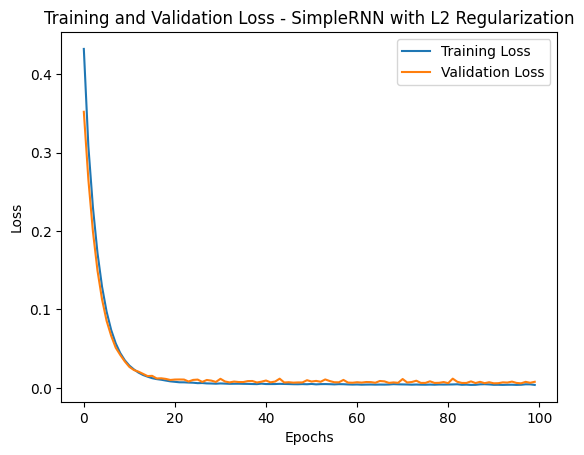

In [12]:
from keras.layers import SimpleRNN, Dense
from keras.regularizers import l2
from keras.models import Sequential

# Modelo SimpleRNN con regularización L2
model_simple_rnn_regularized = Sequential([
    SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.01)),
    Dense(units=32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(units=1)
])

# Compilar el modelo
model_simple_rnn_regularized.compile(optimizer='adam', loss='mean_squared_error')

# Visualizar modelo
model_simple_rnn_regularized.summary()

# Entrenar el modelo
history_simple_rnn = model_simple_rnn_regularized.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Graficar la pérdida durante el entrenamiento para SimpleRNN
plt.plot(history_simple_rnn.history['loss'], label='Training Loss')
plt.plot(history_simple_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - SimpleRNN with L2 Regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Este modelo utiliza una arquitectura SimpleRNN con regularización L2 para predecir valores. El gráfico de pérdida muestra un buen comportamiento, pero se pueden realizar ajustes adicionales para optimizar el rendimiento. La regularización L2 ayuda a mantener la pérdida bajo control y evitar el sobreajuste.

Aún así, realizamos early stopping, una técnica que detiene el entrenamiento cuando la pérdida de validación deja de mejorar

**SimpleRNN mejorada (regularizacióny EarlyStopping)**


Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 64)                4224      
                                                                 
 dense_48 (Dense)            (None, 32)                2080      
                                                                 
 dense_49 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6337 (24.75 KB)
Trainable params: 6337 (24.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
30/30 [==============================] - 4s 22ms/step - loss: 0.0845 - val_loss: 0.0410
Epoch 2/100
30/30 [==============================] - 0s 14ms/step - loss: 0.0340 - val_loss: 0.0320
Epoch 3/100
30/30 [==============================] - 0s 14ms/step - loss: 0.0275 - 

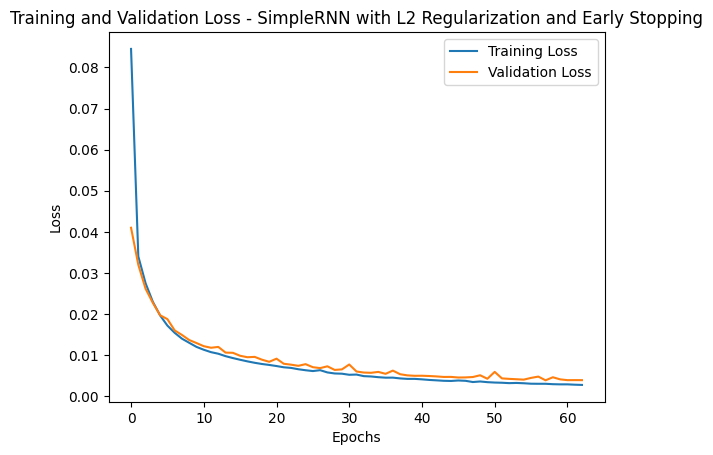

In [77]:
from keras.layers import SimpleRNN, Dense
from keras.regularizers import l2
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Modelo SimpleRNN con regularización L2
model_simple_rnn_regularized = Sequential([
    SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1), kernel_regularizer=l2(0.001)),
    Dense(units=32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(units=1)
])

# Compilar el modelo
model_simple_rnn_regularized.compile(optimizer='adam', loss='mean_squared_error')

# Visualizar modelo
model_simple_rnn_regularized.summary()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo con early stopping
history_simple_rnn = model_simple_rnn_regularized.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Graficar la pérdida durante el entrenamiento para SimpleRNN
plt.plot(history_simple_rnn.history['loss'], label='Training Loss')
plt.plot(history_simple_rnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - SimpleRNN with L2 Regularization and Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Ahora vemos que el gráfico muestra que el modelo ha aprendido patrones de manera efectiva y ha evitado el sobreajuste gracias a la detención temprana. Obtenemos así un buen resultado.

In [78]:
# Evaluación del modelo
test_loss = model_simple_rnn_regularized.evaluate(X_test, y_test)
print("Test Loss:", test_loss)


3/3 [==============================] - 0s 8ms/step - loss: 0.1552
Test Loss: 0.1552405208349228


**LTSM de arquitectura simple**

Las LSTM son una variante avanzada de las redes neuronales recurrentes (RNN) diseñadas para procesar y predecir secuencias de datos. En comparación con las RNN tradicionales, las LSTM utilizan compuertas (gates) para regular el flujo de información a lo largo de la secuencia. Estas compuertas incluyen una compuerta de olvido, una de entrada y una de salida, lo que les permite retener información a largo plazo y capturar dependencias temporales complejas en los datos secuenciales. Además, las LSTM están diseñadas para abordar el problema del desvanecimiento del gradiente, que puede afectar el entrenamiento de las RNN tradicionales.

El desvanecimiento del gradiente puede hacer que las capas profundas de una red neuronal aprendan más lentamente o incluso se estanquen en el aprendizaje, lo que afecta negativamente el rendimiento del modelo. Para abordar este problema, se han desarrollado diversas técnicas, como el uso de funciones de activación especiales (como ReLU en lugar de sigmoides), la normalización de lotes y el uso de arquitecturas de red más avanzadas como las LSTM y las GRU. Estas técnicas ayudan a mitigar el desvanecimiento del gradiente y permiten un entrenamiento más efectivo de redes neuronales profundas.

Epoch 1/100
30/30 [==============================] - 3s 47ms/step - loss: 0.0436 - val_loss: 0.0217
Epoch 2/100
30/30 [==============================] - 1s 37ms/step - loss: 0.0053 - val_loss: 0.0146
Epoch 3/100
30/30 [==============================] - 1s 29ms/step - loss: 0.0045 - val_loss: 0.0133
Epoch 4/100
30/30 [==============================] - 1s 24ms/step - loss: 0.0044 - val_loss: 0.0143
Epoch 5/100
30/30 [==============================] - 1s 24ms/step - loss: 0.0043 - val_loss: 0.0119
Epoch 6/100
30/30 [==============================] - 1s 24ms/step - loss: 0.0041 - val_loss: 0.0126
Epoch 7/100
30/30 [==============================] - 1s 24ms/step - loss: 0.0041 - val_loss: 0.0121
Epoch 8/100
30/30 [==============================] - 1s 24ms/step - loss: 0.0040 - val_loss: 0.0106
Epoch 9/100
30/30 [==============================] - 1s 24ms/step - loss: 0.0038 - val_loss: 0.0096
Epoch 10/100
30/30 [==============================] - 1s 25ms/step - loss: 0.0036 - val_loss: 0.0084

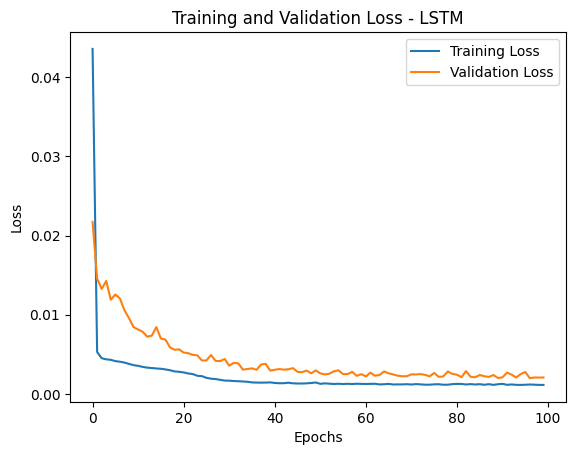

In [59]:
from keras.layers import LSTM

# Modelo LSTM sencillo
model_lstm = Sequential([
    LSTM(units=32, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(units=1)
])

# Compilar el modelo
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history_lstm = model_lstm.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

model_lstm.summary()

# Graficar la pérdida durante el entrenamiento para LSTM
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Al comienzo del entrenamiento, las pérdidas de entrenamiento y validación disminuyen rápidamente, lo que sugiere que el modelo está aprendiendo rápidamente los patrones en los datos de entrenamiento.

Posterior al descenso inicial, ambas curvas de pérdida se estabilizan. La convergencia cercana entre la pérdida de entrenamiento y la de validación indica una buena capacidad de generalización del modelo.

La pérdida relativamente baja señala que el modelo está haciendo buenas predicciones, lo que sugiere una efectiva capacidad de aprendizaje.

Como nota, debemos estar atentos a signos de sobreajuste, especialmente si la pérdida de validación comienza a aumentar en comparación con la pérdida de entrenamiento. Por ello, vamos a explorar diferentes arquitecturas, hiperparámetros y técnicas de regularización para mejorar aún más el rendimiento del modelo.

In [48]:
# Evaluación del modelo en el conjunto de prueba
test_loss_lstm = model_lstm.evaluate(X_test, y_test)
print("Test Loss (LSTM):", test_loss_lstm)


3/3 [==============================] - 0s 84ms/step - loss: 0.6979
Test Loss (LSTM): 0.6979109048843384


**LTSM mejorado (dropout y EarlyStopping)**

In [83]:
from keras.layers import LSTM, Dropout
from keras.callbacks import EarlyStopping

# Modelo LSTM mejorado con EarlyStopping y Dropout
model_lstm_improved = Sequential()
model_lstm_improved.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
model_lstm_improved.add(Dropout(0.2))
model_lstm_improved.add(LSTM(units=64, return_sequences=True, activation='tanh'))
model_lstm_improved.add(Dropout(0.2))
model_lstm_improved.add(LSTM(units=64, activation='tanh'))
model_lstm_improved.add(Dropout(0.2))
model_lstm_improved.add(Dense(units=1))

# Compilar el modelo LSTM mejorado
model_lstm_improved.compile(optimizer='adam', loss='mean_squared_error')

# Definir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo LSTM mejorado con EarlyStopping
history_lstm_improved = model_lstm_improved.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Visualizar modelo
model_lstm_improved.summary()

# Graficar la pérdida durante el entrenamiento del modelo LSTM mejorado
plt.plot(history_lstm_improved.history['loss'], label='Training Loss')
plt.plot(history_lstm_improved.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - Improved LSTM with EarlyStopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/100
30/30 [==============================] - 11s 144ms/step - loss: 0.0397 - val_loss: 0.0290
Epoch 2/100
30/30 [==============================] - 4s 137ms/step - loss: 0.0112 - val_loss: 0.0286
Epoch 3/100
30/30 [==============================] - 3s 99ms/step - loss: 0.0109 - val_loss: 0.0200
Epoch 4/100
30/30 [==============================] - 3s 99ms/step - loss: 0.0089 - val_loss: 0.0151
Epoch 5/100
30/30 [==============================] - 3s 100ms/step - loss: 0.0088 - val_loss: 0.0129
Epoch 6/100
30/30 [==============================] - 4s 138ms/step - loss: 0.0100 - val_loss: 0.0159
Epoch 7/100
30/30 [==============================] - 3s 99ms/step - loss: 0.0087 - val_loss: 0.0096
Epoch 8/100
30/30 [==============================] - 3s 100ms/step - loss: 0.0078 - val_loss: 0.0122
Epoch 9/100
30/30 [==============================] - 3s 100ms/step - loss: 0.0072 - val_loss: 0.0152
Epoch 10/100
30/30 [==============================] - 4s 136ms/step - loss: 0.0072 - val_loss

KeyboardInterrupt: 

Un dropout del 0.2 significa que durante el entrenamiento, el 20% de las unidades en la capa correspondiente se "apagan" aleatoriamente en cada paso de entrenamiento.

Cuando se apaga una unidad, significa que su salida se establece en cero y no se considera en el proceso de propagación hacia atrás durante ese paso de entrenamiento. Esto se hace de manera aleatoria para cada unidad en la capa en cada paso de entrenamiento, lo que ayuda a prevenir el sobreajuste al introducir ruido en la red neuronal y obligarla a aprender de manera más robusta y generalizable.

Aqui vemos como el modelo no converge rapidamente añadiendo una regularización dropout bastante baja.

In [89]:
# Evaluación del modelo en el conjunto de prueba
test_loss_lstm_improved = model_lstm_improved.evaluate(X_test, y_test)
print("Test Loss (Improved LSTM):", test_loss_lstm_improved)


3/3 [==============================] - 0s 34ms/step - loss: 0.8019
Test Loss (Improved LSTM): 0.8018775582313538


**GRU simple**

Las GRU son una versión simplificada de las LSTM, con menos componentes y menos parámetros, lo que las hace más eficientes computacionalmente y menos propensas al sobreajuste en conjuntos de datos más pequeños. Sin embargo, las LSTM pueden ser más poderosas y capturar relaciones de largo plazo en secuencias más complejas debido a su estructura más elaborada y capacidad para almacenar y olvidar información durante períodos de tiempo más largos. En resumen, las GRU pueden ser más adecuadas para conjuntos de datos más pequeños y tareas más simples, mientras que las LSTM pueden ser preferibles para tareas más complejas que requieren una memoria a largo plazo más robusta.

Epoch 1/100
30/30 [==============================] - 4s 48ms/step - loss: 0.1025 - val_loss: 0.0270
Epoch 2/100
30/30 [==============================] - 1s 23ms/step - loss: 0.0093 - val_loss: 0.0073
Epoch 3/100
30/30 [==============================] - 1s 23ms/step - loss: 0.0042 - val_loss: 0.0045
Epoch 4/100
30/30 [==============================] - 1s 24ms/step - loss: 0.0020 - val_loss: 0.0036
Epoch 5/100
30/30 [==============================] - 1s 23ms/step - loss: 0.0017 - val_loss: 0.0040
Epoch 6/100
30/30 [==============================] - 1s 40ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 7/100
30/30 [==============================] - 1s 24ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 8/100
30/30 [==============================] - 1s 34ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 9/100
30/30 [==============================] - 1s 35ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 10/100
30/30 [==============================] - 1s 35ms/step - loss: 0.0015 - val_loss: 0.0033

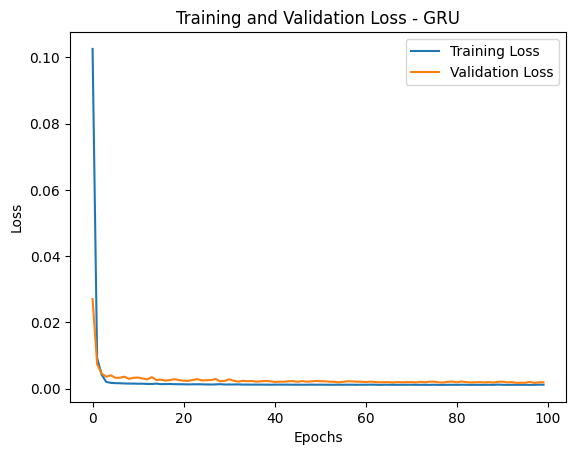

In [42]:
from keras.layers import GRU

# Modelo GRU sencillo
model_gru = Sequential([
    GRU(units=32, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(units=1)
])

# Compilar el modelo
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history_gru = model_gru.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))

# Visualizar modelo
model_gru.summary()

# Graficar la pérdida durante el entrenamiento para GRU
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


El modelo GRU consta de una capa GRU con 32 unidades y función de activación ReLU.

Se agrega una capa densa con 1 unidad para la predicción final.

Asi, tras ver los resultados vemos como el modelo converge muy rapidamente y mejora muy poco con el paso de las epochs. Por lo tanto vamos a realizar regularización y early stopping.



In [69]:
# Evaluación del modelo en el conjunto de prueba
test_loss_gru = model_gru.evaluate(X_test, y_test)
print("Test Loss (GRU):", test_loss_gru)


3/3 [==============================] - 0s 13ms/step - loss: 0.1870
Test Loss (GRU): 0.1869763731956482


**GRU mejorado (regularización y EarlyStopping)**

Epoch 1/100
30/30 [==============================] - 4s 45ms/step - loss: 0.2392 - val_loss: 0.1149
Epoch 2/100
30/30 [==============================] - 1s 26ms/step - loss: 0.0478 - val_loss: 0.0304
Epoch 3/100
30/30 [==============================] - 1s 26ms/step - loss: 0.0305 - val_loss: 0.0287
Epoch 4/100
30/30 [==============================] - 1s 25ms/step - loss: 0.0254 - val_loss: 0.0250
Epoch 5/100
30/30 [==============================] - 1s 25ms/step - loss: 0.0218 - val_loss: 0.0228
Epoch 6/100
30/30 [==============================] - 1s 25ms/step - loss: 0.0201 - val_loss: 0.0206
Epoch 7/100
30/30 [==============================] - 1s 31ms/step - loss: 0.0187 - val_loss: 0.0200
Epoch 8/100
30/30 [==============================] - 1s 38ms/step - loss: 0.0174 - val_loss: 0.0188
Epoch 9/100
30/30 [==============================] - 1s 39ms/step - loss: 0.0163 - val_loss: 0.0175
Epoch 10/100
30/30 [==============================] - 1s 26ms/step - loss: 0.0152 - val_loss: 0.0174

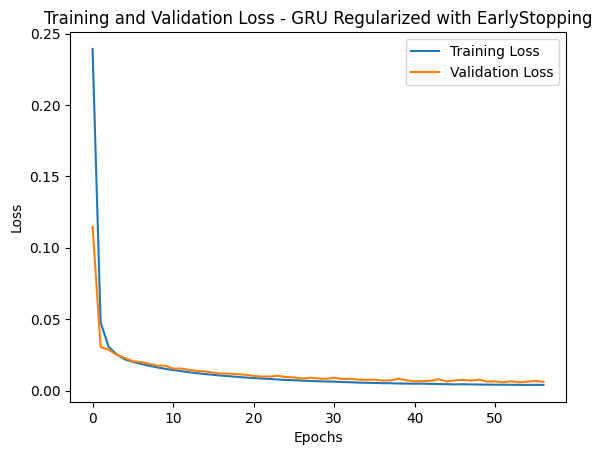

In [60]:
from keras.layers import GRU
from keras.callbacks import EarlyStopping

# Modelo GRU mejorado con regularización L2 y EarlyStopping
model_gru_early_stopping = Sequential([
    GRU(units=32, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1], 1)),
    Dense(units=1, kernel_regularizer=l2(0.01))
])

# Compilar el modelo
model_gru_early_stopping.compile(optimizer='adam', loss='mean_squared_error')

# Definir EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo con EarlyStopping
history_gru_early_stopping = model_gru_early_stopping.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

model_gru_early_stopping.summary()

# Graficar la pérdida durante el entrenamiento para GRU regularizado con EarlyStopping
plt.plot(history_gru_early_stopping.history['loss'], label='Training Loss')
plt.plot(history_gru_early_stopping.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss - GRU Regularized with EarlyStopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


En el nuevo modelo, la pérdida de entrenamiento disminuye rápidamente en las primeras épocas y luego se estabiliza.

La pérdida final es más baja que en el modelo anterior, lo que indica que el modelo ha aprendido mejor los patrones en los datos de entrenamiento.Además, la pérdida de validación también disminuye inicialmente y luego se estabiliza.

Por otro lado, la convergencia cercana entre la pérdida de entrenamiento y la de validación sugiere que el modelo generaliza bien a datos no vistos.

En general, estos resultados son mejores que los anteriores (sin regularización L2 y early stopping).

La regularización L2 ayuda a prevenir el sobreajuste, y el early stopping evita que el modelo continúe entrenando innecesariamente.

En resumen, este nuevo modelo parece ser una mejora en términos de pérdida y generalización.

In [61]:
# Evaluación del modelo en el conjunto de prueba
test_loss_gru_early_stopping = model_gru_early_stopping.evaluate(X_test, y_test)
print("Test Loss (GRU with Early Stopping):", test_loss_gru_early_stopping)


3/3 [==============================] - 0s 10ms/step - loss: 0.0932
Test Loss (GRU with Early Stopping): 0.09321893006563187


# **Conclusiones**

Una vez entrenados y evaluados todos los modelos, decidimos que modelo seleccionar.

In [74]:
test_loss = model_simple_rnn.evaluate(X_test, y_test)
print("Test Loss SimpleRNN:", test_loss)

3/3 [==============================] - 0s 10ms/step - loss: 0.3750
Test Loss SimpleRNN: 0.37498340010643005


In [79]:
test_loss = model_simple_rnn_regularized.evaluate(X_test, y_test)
print("Test Loss SImpleRNN mejorado:", test_loss)

3/3 [==============================] - 0s 12ms/step - loss: 0.1552
Test Loss: 0.1552405208349228


In [80]:
test_loss_lstm = model_lstm.evaluate(X_test, y_test)
print("Test Loss (LSTM simple):", test_loss_lstm)

3/3 [==============================] - 0s 17ms/step - loss: 4.1842
Test Loss (LSTM): 4.184231758117676


In [81]:
test_loss_lstm_improved = model_lstm_improved.evaluate(X_test, y_test)
print("Test Loss (Mejorado LSTM):", test_loss_lstm_improved)

3/3 [==============================] - 0s 24ms/step - loss: 0.1031
Test Loss (Improved LSTM): 0.10310623049736023


In [90]:
test_loss_gru = model_gru.evaluate(X_test, y_test)
print("Test Loss (GRU):", test_loss_gru)


3/3 [==============================] - 0s 20ms/step - loss: 0.1870
Test Loss (GRU): 0.1869763731956482


In [91]:
test_loss_gru_early_stopping = model_gru_early_stopping.evaluate(X_test, y_test)
print("Test Loss (GRU Mejorado):", test_loss_gru_early_stopping)

3/3 [==============================] - 0s 14ms/step - loss: 0.0932
Test Loss (GRU with Early Stopping): 0.09321893006563187


Los modelos simples, como SimpleRNN, LSTM Simple y GRU Simple, han demostrado un rendimiento notable tanto en los conjuntos de entrenamiento como en los de prueba. Dado que estamos tratando con datos de series temporales de precios de acciones de Tesla, que pueden seguir patrones simples y predecibles en cierta medida, no es sorprendente que estos modelos simples logren buenos resultados.

Por otro lado, los modelos mejorados, como el LSTM Mejorado y el GRU Mejorado con Early Stopping, han demostrado un rendimiento superior en ambos conjuntos de datos. Estos modelos incorporan técnicas como regularización y dropout para evitar el sobreajuste, así como Early Stopping para detener el entrenamiento cuando no se observa mejora en el conjunto de validación. Es interesante notar que, aunque LSTM y GRU son tipos diferentes de células de memoria recurrente, ambos han demostrado ser efectivos en este caso. La principal diferencia radica en la forma en que manejan la información de estado oculta y las puertas de actualización. Mientras que LSTM utiliza puertas de olvido, entrada y salida, GRU utiliza solo dos puertas: reinicio y actualización.

Como reflexion personal es sorprendente que el rendimiento de LSTM no sea tan bueno en este caso de uso de series temporales por varias razones. Tradicionalmente, LSTM se considera una opción robusta para modelar series temporales debido a su capacidad para capturar dependencias a largo plazo en los datos secuenciales. Sin embargo, en este caso específico de predicción de precios de acciones de Tesla, los resultados de LSTM pueden no ser tan buenos por varias razones posibles:

*   Complejidad del modelo: Aunque LSTM es potente para capturar patrones complejos en los datos secuenciales, también puede ser propenso al sobreajuste, especialmente en conjuntos de datos relativamente pequeños o con pocos datos de entrenamiento.
*   Arquitectura del modelo: La arquitectura de LSTM puede no ser la más adecuada para este conjunto de datos específico. Aunque LSTM es capaz de aprender dependencias a largo plazo, también tiene más parámetros y puede ser más propenso al sobreajuste en comparación con otros modelos más simples como SimpleRNN o GRU.



# **Proyección futura**


Como siguiente paso potencial en nuestro trabajo, una vez seleccionados 2 o 3 modelos prometedores de entre los evaluados, sería realizar predicciones para el precio de cierre de la acción de Tesla en el día siguiente. Esta actividad nos permitiría no solo evaluar el rendimiento de los modelos en términos de la métrica de pérdida, sino también comprender cómo se comportan en la práctica al hacer predicciones del mundo real.

Al predecir el precio de cierre del día siguiente, podríamos obtener una idea más clara de la capacidad de los modelos para anticipar cambios en el mercado de valores y capturar patrones de fluctuación de precios. Además, nos permitiría comparar las predicciones generadas por diferentes modelos y determinar cuál ofrece las proyecciones más precisas y útiles.

Dado que nuestro enfoque se ha centrado principalmente en la evaluación de modelos RNN aplicados al caso de uso de series temporales de precios de acciones de Tesla, la realización de predicciones en tiempo real se deja como una sugerencia para futuras investigaciones o implementaciones prácticas